In [1]:
import scanpy as sc
import scvi
import numpy as np
import pandas as pd
import anndata
import os



In [2]:
import sys
#if True, will install via pypi, else will install from source
stable = True
IN_COLAB = "google.colab" in sys.modules

In [3]:
counts = pd.read_csv('data/star_counts.tab', sep='\t', index_col=0)
rd = pd.read_csv('data/rd_pc2.tab', sep='\t', index_col=0)
meta = pd.read_csv('data/SraRunTable.txt', index_col=0)
star_meta = pd.read_csv('data/star_meta.tab', sep='\t', index_col=0)

discard = ['EGFP'] + [x for x in counts.index if x[:5]=='ERCC-']
good_genes = [x for x in counts.index if x not in discard]
counts = counts.loc[good_genes, rd.index].T

In [4]:
gene_len = pd.read_csv(
    "https://raw.githubusercontent.com/chenlingantelope/HarmonizationSCANVI/master/data/gene_len.txt",
    delimiter=" ",
    header=None,
    index_col=0,
)
gene_len.head()

,1
0,
0610007C21Rik,94.571429
0610007L01Rik,156.000000
0610007P08Rik,202.272727
0610007P14Rik,104.000000
0610007P22Rik,158.750000


(20508, 1)

In [32]:


adata = anndata.AnnData(counts)

sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)

adata.layers["counts"] = adata.X.copy()

gene_len = gene_len.reindex(adata.var.index).dropna()
adata = adata[:, gene_len.index]
assert (adata.var.index == gene_len.index).sum() == adata.shape[1]
adata.X = adata.X / gene_len[1].values * np.median(gene_len[1].values)
# round to integer
adata.X = np.rint(adata.X)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

adata.obs['Age'] = meta.loc[adata.obs.index].Age

scvi.data.setup_anndata(adata, layer="counts")



sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=True,
    layer="counts",
#     batch_key="Age",
    flavor="seurat_v3"
)


scvi.data.setup_anndata(adata, layer="counts")
scvi.settings.seed = 0
model = scvi.model.LinearSCVI(adata, n_latent=3)


model.train()


# model.save("tiklova_neurogenesis/")

# model = scvi.model.LinearSCVI.load("my_model/", adata)

latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

sc.pp.neighbors(adata, use_rep="X_scVI")

sc.tl.pca(adata)



/home/eecs/cfbuenabadn/anaconda3/envs/scvi-env/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 1197 cells, 15612 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]             

/home/eecs/cfbuenabadn/anaconda3/envs/scvi-env/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


Training...: 100%|██████████| 400/400 [00:49<00:00,  8.01it/s]
INFO     Training time:  49 s. / 400 epochs                                                  


... storing 'Age' as categorical


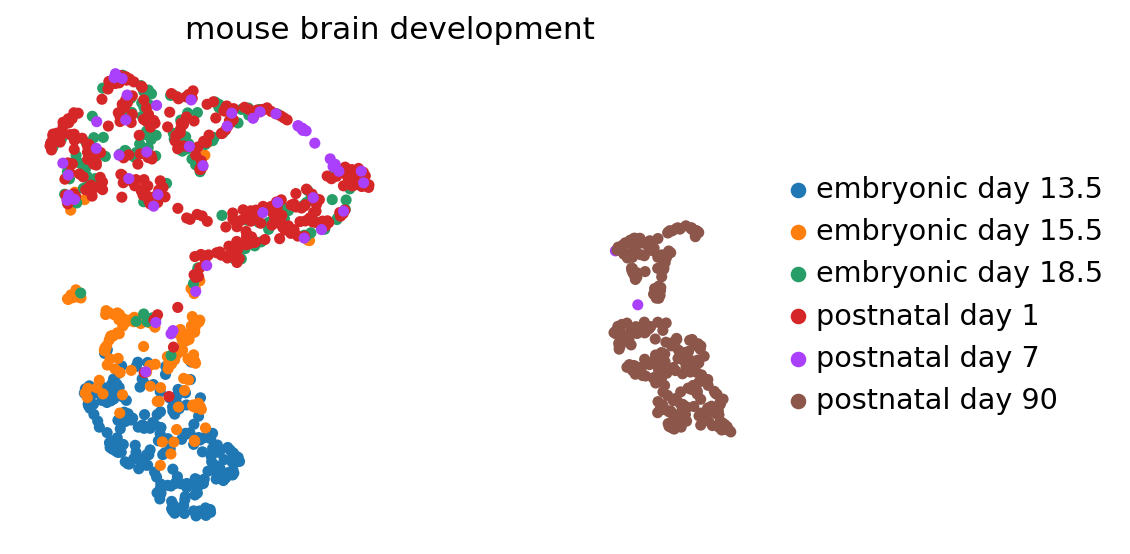

In [33]:
sc.set_figure_params(figsize=(6, 4))

sc.tl.umap(adata, min_dist=0.2)

sc.pl.umap(
    adata,
    color="Age",
    frameon=False,
    title='mouse brain development'
)


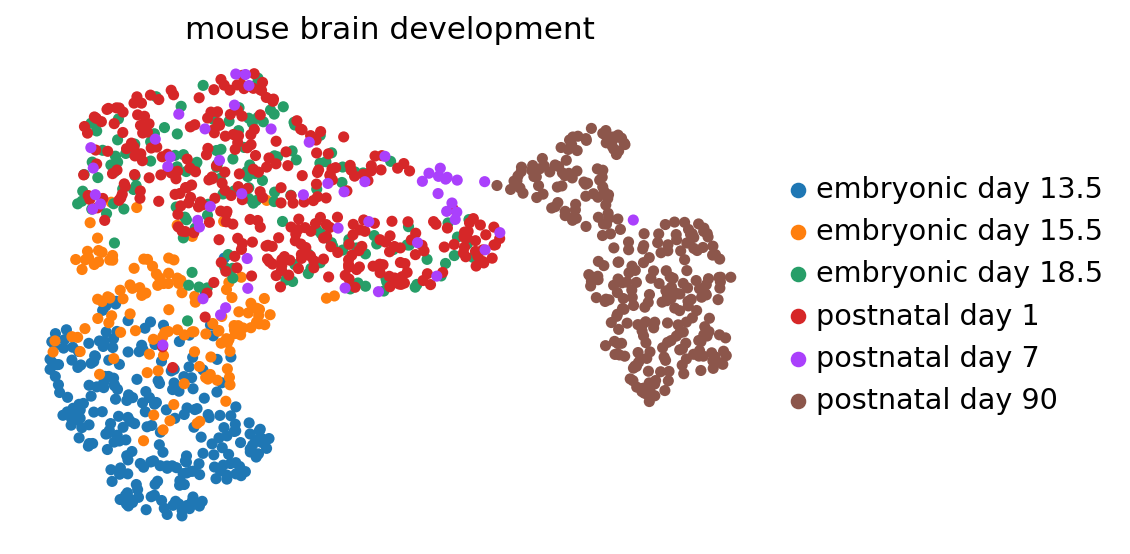

In [34]:
sc.tl.umap(adata, min_dist=0.75)

sc.pl.umap(
    adata,
    color="Age",
    frameon=False,
    title='mouse brain development'
)

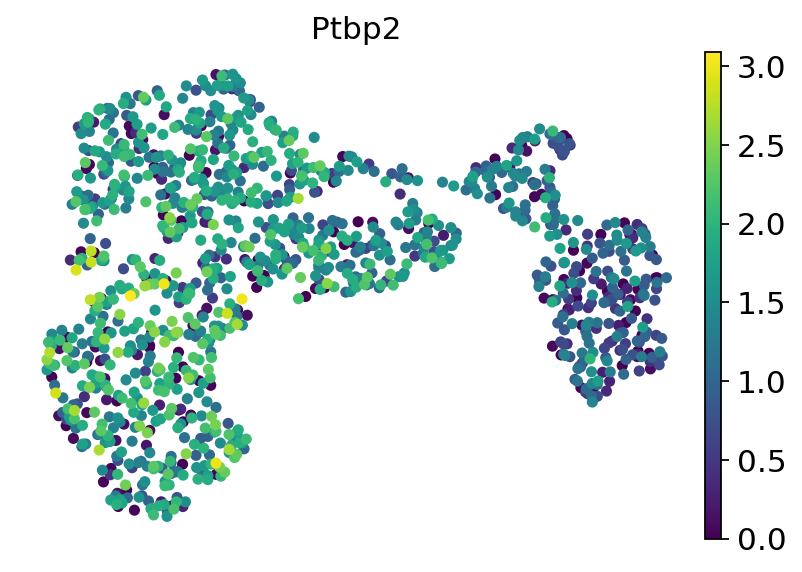

In [136]:
sc.pl.umap(
    adata,
    color="Ptbp2",
    frameon=False,
)

In [124]:
model.save("tiklova_neurogenesis/")


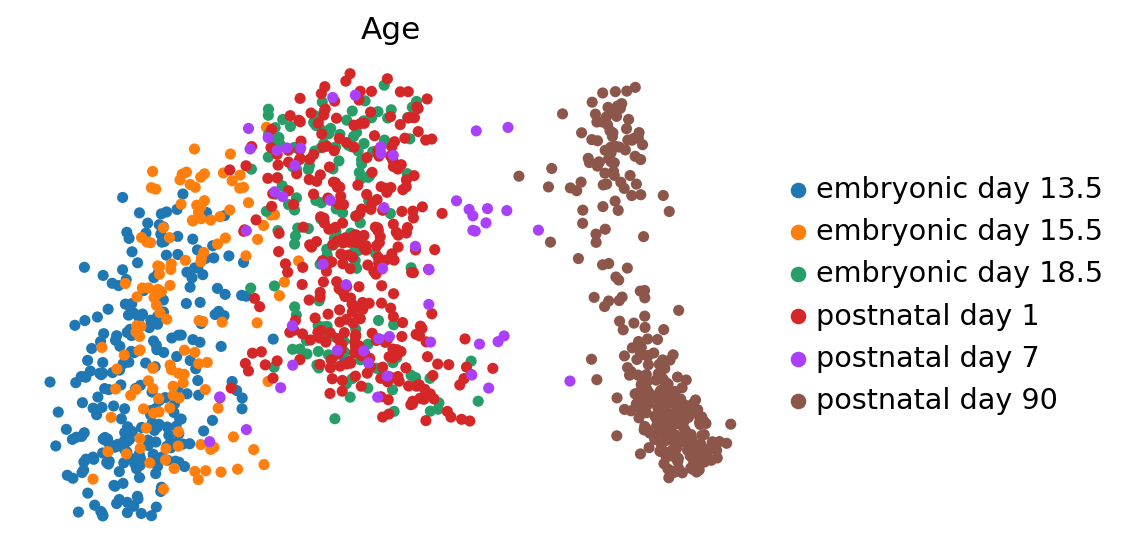

In [103]:
sc.pl.pca(
    adata,
    color="Age",
    frameon=False,
)

In [127]:
scvi_rd = pd.DataFrame(adata.obsm['X_scVI'])
scvi_rd.index = adata.obs.index
scvi_rd.columns = ['scvi_' + str(x) for x in range(1, 4)]

scvi_rd.to_csv('scvi_rd_tiklova.tab', sep='\t', index=True, header=True)

In [6]:
scvi_rd_old = pd.read_csv('scvi_rd.tab', sep='\t', index_col=0)

In [7]:
scvi_rd = pd.DataFrame(adata.obsm['X_scVI'])
scvi_rd.index = adata.obs.index
scvi_rd.columns = ['scvi_' + str(x) for x in range(1, 11)]

In [15]:
scvi_rd_old

,scvi_1,scvi_2,scvi_3,scvi_4,scvi_5,scvi_6,scvi_7,scvi_8,scvi_9,scvi_10
SRR7408400,1.306731,-1.536949,1.562989,1.670806,-0.363751,0.185112,1.043335,-0.120652,0.542777,0.833499
SRR7408401,2.026553,-0.410312,1.212092,1.212790,-1.167937,0.828602,-0.631216,0.730819,1.200134,1.379625
SRR7408404,1.500146,-1.382855,0.751870,1.375458,-0.370985,0.346029,-2.757409,1.076205,0.843649,0.906712
SRR7408413,1.870672,-0.757629,1.687618,0.967949,-0.043531,1.084393,-0.049187,0.910763,1.594701,0.961260
SRR7408414,0.482476,-0.281556,0.206009,1.241226,-0.805917,0.595564,-1.815846,0.552810,0.358233,2.445393
...,...,...,...,...,...,...,...,...,...,...
SRR7410092,-1.492256,-1.451774,-1.193638,-3.065494,-0.040890,-0.371669,-0.736266,0.957174,-0.387957,0.139207
SRR7410093,-1.826546,0.043637,0.849731,0.115364,0.561314,-1.943042,-1.380151,-1.051772,1.050279,-2.245166
SRR7410094,1.020857,0.044194,-1.067666,-2.755551,0.773470,-2.777790,-1.282106,-1.388226,-0.157771,-1.332365
SRR7410096,-0.388211,-0.902124,0.721776,-0.520365,-0.128789,-0.739533,-0.393019,0.554119,1.512115,-3.595692


In [62]:
adata.obs

,n_counts,Age,_scvi_batch,_scvi_labels,_scvi_local_l_mean,_scvi_local_l_var
SRR7408400,492781.0,embryonic day 13.5,0,0,11.231376,0.288807
SRR7408401,804769.0,embryonic day 13.5,0,0,11.231376,0.288807
SRR7408404,1562686.0,embryonic day 13.5,0,0,11.231376,0.288807
SRR7408413,707476.0,embryonic day 13.5,0,0,11.231376,0.288807
SRR7408414,1402388.0,embryonic day 13.5,0,0,11.231376,0.288807
...,...,...,...,...,...,...
SRR7410092,2926984.0,postnatal day 90,0,0,11.231376,0.288807
SRR7410093,946422.0,postnatal day 90,0,0,11.231376,0.288807
SRR7410094,2021391.0,postnatal day 90,0,0,11.231376,0.288807
SRR7410096,1090482.0,postnatal day 90,0,0,11.231376,0.288807


In [16]:
scvi_rd

,scvi_1,scvi_2,scvi_3,scvi_4,scvi_5,scvi_6,scvi_7,scvi_8,scvi_9,scvi_10
SRR7408400,-0.198298,-1.346736,-0.503973,1.798857,0.238503,1.062477,-0.132869,0.358801,-0.884362,-0.419263
SRR7408401,1.496758,-0.286099,0.514262,1.952907,-1.116577,0.834256,0.259684,1.165933,0.183338,0.210745
SRR7408404,1.278691,0.433284,0.321137,1.508092,-0.270188,0.242249,-1.886693,0.844178,0.235630,-0.100312
SRR7408413,0.427795,-0.222243,0.119142,2.306835,0.479888,0.077370,0.244513,1.085632,1.084411,-0.144963
SRR7408414,0.896169,-1.045920,0.590931,-0.029716,-1.064434,1.945587,-1.656533,1.427332,0.559370,0.438540
...,...,...,...,...,...,...,...,...,...,...
SRR7410092,-0.029245,-1.080601,0.716544,-3.219305,0.440480,-1.639058,-0.980317,1.421482,-0.117269,-0.000148
SRR7410093,-0.690074,1.082216,-0.791490,0.063707,-0.105117,-0.522863,-1.337617,-1.859223,-1.867523,-0.210472
SRR7410094,1.834816,-1.136984,-1.315767,-2.250585,0.662962,-1.450702,-0.934854,-0.881359,-0.414529,-1.733078
SRR7410096,-0.304296,0.979550,1.919737,-0.394494,-0.406118,-1.219350,-0.203409,-0.387927,-1.019765,-0.958635


In [128]:
adata.write_csvs('tiklova_neurogenesis_anndata')

writing .csv files to tiklova_neurogenesis_anndata


In [15]:
adata.layers

Layers with keys: counts, scvi_normalized

In [9]:
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
colores = []
for cell in adata.obs.Age:
    if cell == 'embryonic day 13.5':
        colores.append('darkred')
    if cell == 'embryonic day 15.5':
        colores.append('darkorange')
    if cell == 'embryonic day 18.5':
        colores.append('forestgreen')
    if cell == 'postnatal day 1':
        colores.append('skyblue')
    if cell == 'postnatal day 7':
        colores.append('indigo')
    if cell == 'postnatal day 90':
        colores.append('navy')

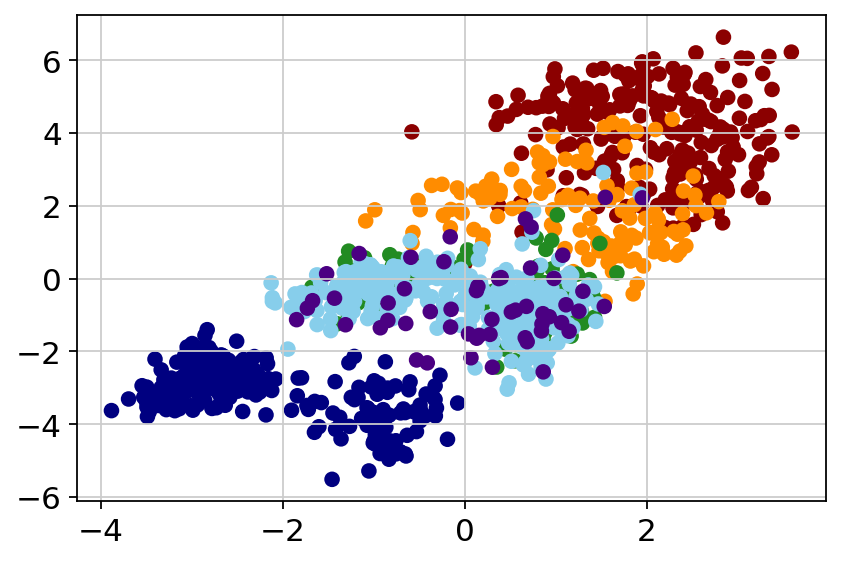

In [36]:
plt.scatter(adata.obsm['X_scVI'].T[0], adata.obsm['X_scVI'].T[1], c=colores)

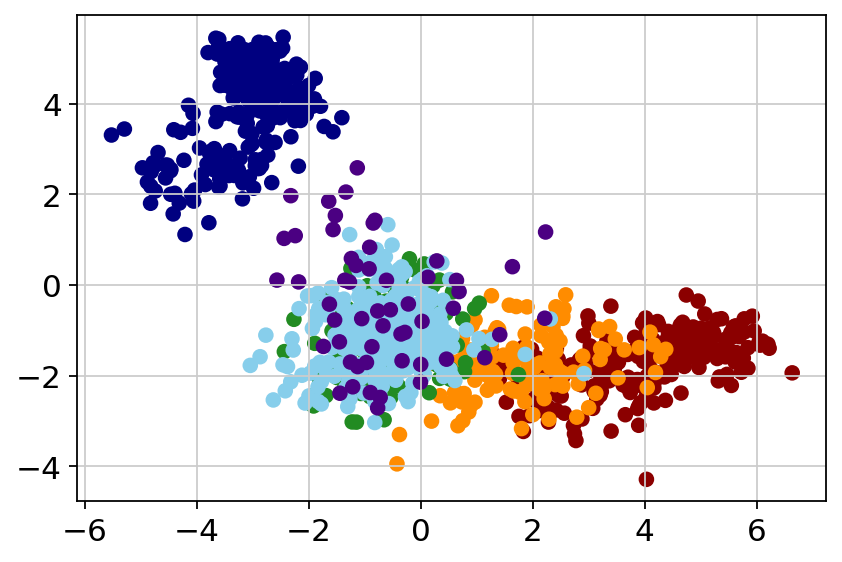

In [35]:
plt.scatter(adata.obsm['X_scVI'].T[1], adata.obsm['X_scVI'].T[2], c=colores)

In [37]:
pc = PCA(2).fit_transform(adata.obsm['X_scVI'])

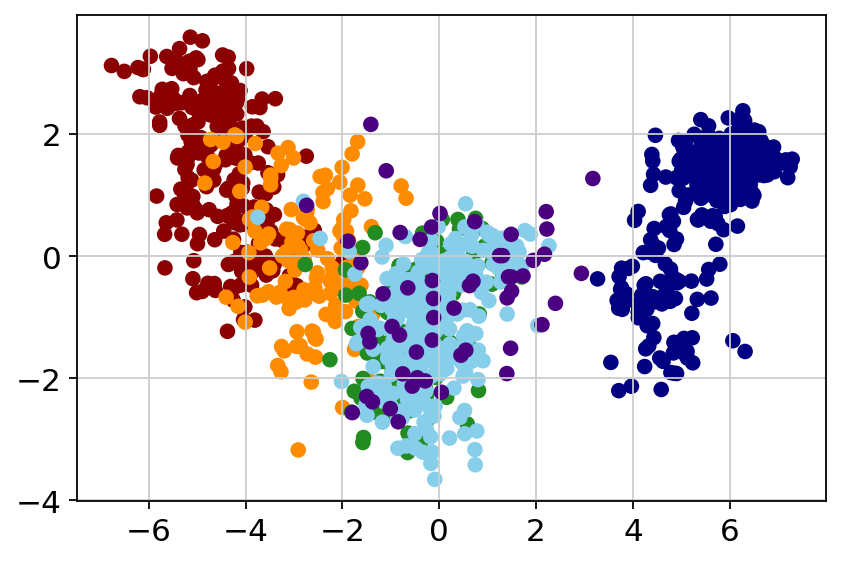

In [39]:
plt.scatter(pc.T[0], -pc.T[1], c=colores)

In [113]:
de_df = model.differential_expression(
    groupby="Age",
    group1="embryonic day 13.5",
    group2="postnatal day 90"
)
de_df.head()

Output()

,proba_de,proba_not_de,bayes_factor,scale1,scale2,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,comparison
mgi_symbol,,,,,,,,,,,,,,,,,
Draxin,1.0,0.0,18.420681,0.002701,0.000188,3.874116,3.911210,0.702793,1.179499,6.460073,475.252075,1.100694,0.830579,0.020833,37.827995,0.058856,embryonic day 13.5 vs postnatal day 90
Cntnap2,1.0,0.0,18.420681,0.000855,0.004780,-2.503530,-2.509409,0.656718,-4.766861,-0.323127,96.144630,718.260437,0.479339,0.986111,7.575963,59.034424,embryonic day 13.5 vs postnatal day 90
Plekhb2,1.0,0.0,18.420681,0.001551,0.010122,-2.689084,-2.717662,0.493617,-4.348550,-0.703227,205.020660,1500.215332,0.723140,1.000000,18.732759,123.472969,embryonic day 13.5 vs postnatal day 90
Cd24a,1.0,0.0,18.420681,0.013773,0.001189,3.547152,3.563553,0.529755,0.918829,5.208864,3087.942139,49.989582,1.000000,0.350694,264.938904,5.075899,embryonic day 13.5 vs postnatal day 90
Gm43200,1.0,0.0,18.420681,0.000500,0.000080,2.682668,2.686079,0.685411,0.254577,5.346125,4.681818,0.170139,0.045455,0.006944,0.429696,0.027040,embryonic day 13.5 vs postnatal day 90


In [115]:
de_df = model.differential_expression(
    groupby="Age",
)
de_df.head()

Output()

,proba_de,proba_not_de,bayes_factor,scale1,scale2,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,comparison
mgi_symbol,,,,,,,,,,,,,,,,,
Obscn,0.9876,0.0124,4.377580,0.000021,0.000288,-3.584011,-3.636467,1.634589,-9.155696,3.410113,0.165289,4.058639,0.057851,0.048168,0.022993,0.407119,embryonic day 13.5 vs Rest
Tuba4a,0.9858,0.0142,4.240211,0.000036,0.002201,-5.041151,-5.182115,2.825626,-11.657763,4.723454,3.776860,275.390564,0.475207,0.658639,0.322484,23.092096,embryonic day 13.5 vs Rest
Tns1,0.9824,0.0176,4.022099,0.000046,0.000348,-2.902802,-3.037502,1.428634,-7.151577,3.095319,0.033058,5.912042,0.033058,0.059686,0.003681,0.509890,embryonic day 13.5 vs Rest
Phxr4,0.9792,0.0208,3.851782,0.000544,0.000092,3.314757,3.059240,2.005088,-2.007904,10.184614,2.789256,0.267016,0.016529,0.010471,0.284063,0.033606,embryonic day 13.5 vs Rest
Gm11525,0.9774,0.0226,3.766946,0.000038,0.000262,-2.654510,-2.771696,1.275943,-6.120420,2.108328,0.004132,1.271204,0.004132,0.017801,0.000293,0.108766,embryonic day 13.5 vs Rest


In [117]:
markers = {}
cats = adata.obs.Age.cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    Age_df = de_df.loc[de_df.comparison == cid]
    Age_df = Age_df.sort_values("lfc_mean", ascending=False)

    Age_df = Age_df[Age_df.lfc_mean > 0]

    Age_df = Age_df[Age_df["bayes_factor"] > 3]
    Age_df = Age_df[Age_df["non_zeros_proportion1"] > 0.1]

    markers[c] = Age_df.index.tolist()[:3]

In [118]:
sc.tl.dendrogram(adata, groupby="Age", use_rep="X_scVI")


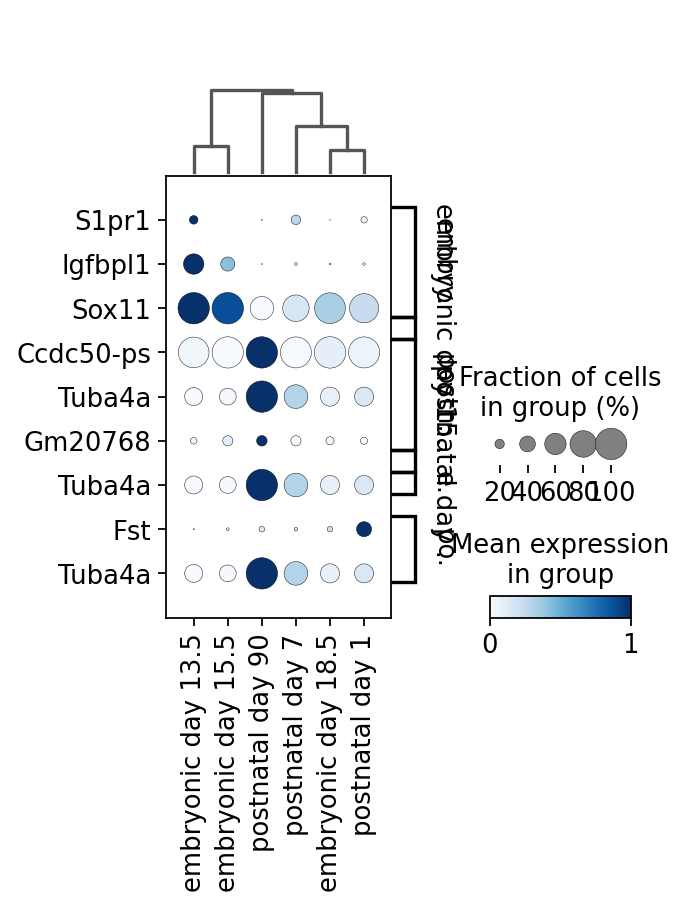

In [119]:
sc.pl.dotplot(
    adata,
    markers,
    groupby='Age',
    dendrogram=True,
    color_map="Blues",
    swap_axes=True,
    use_raw=True,
    standard_scale="var",
)

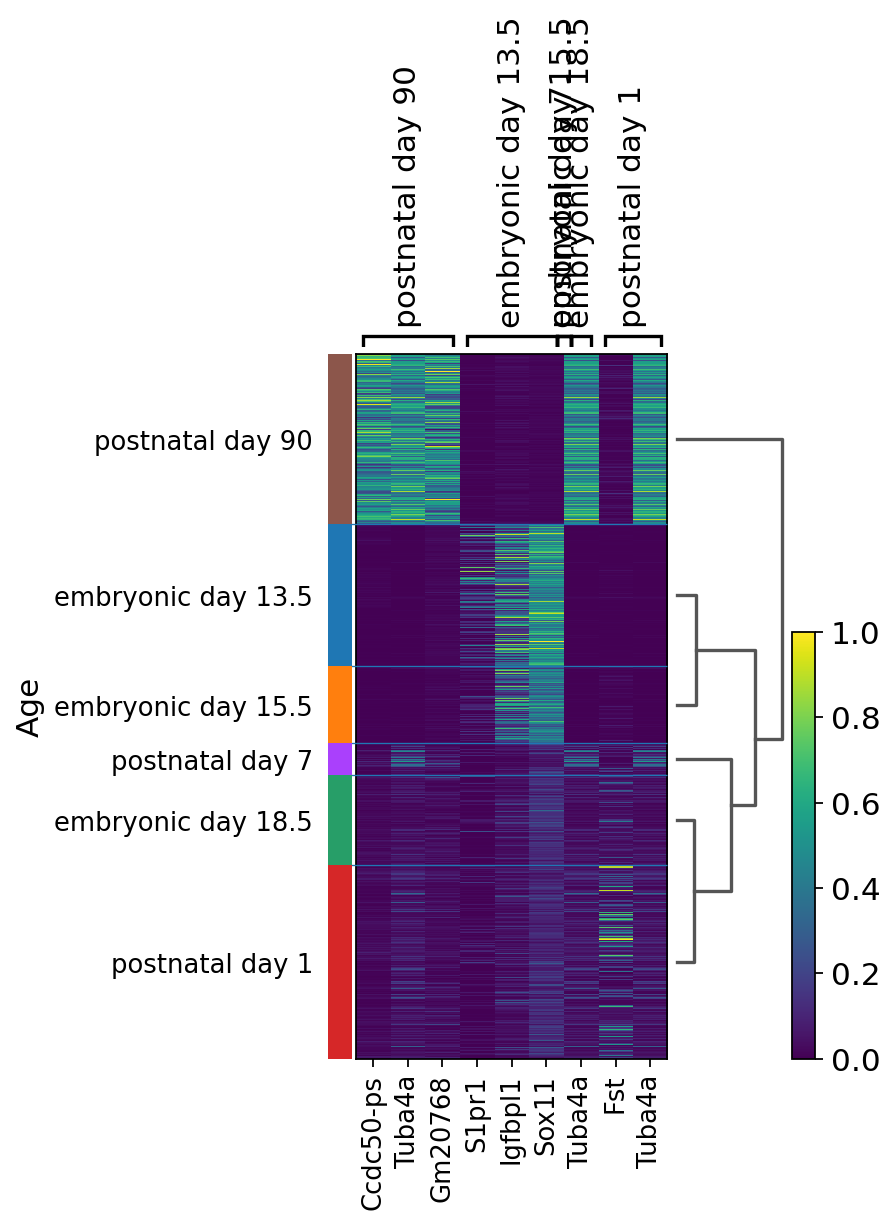

In [120]:
sc.pl.heatmap(
    adata,
    markers,
    groupby='Age',
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
)

In [4]:
scvi.__version__

'0.8.1'